# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

# Indice

1. [Introducción](#titulo_principal)
2. [Inicialización](#titulo_principal_1)
3. [Carga de datos](#titulo_principal_2)
4. [EDA](#titulo_principal_3)
5. [Procedimiento de evaluación](#titulo_principal_4)
6. [Normalización](#titulo_principal_5)
7. [División entrenamiento / pueba](#titulo_principal_6)
8. [Trabajo con modelos](#titulo_principal_7)
9. [Reseñas](#titulo_principal_8)
10. [Conclusiónes](#titulo_principal_9)
11. [Trabajo con modelos](#titulo_principal_10)

## Introducción <a id="titulo_principal"></a>

En este proyecto se realizara una limpieza, procesado y visualización de datos acerca de las reseñas de peliculas. Se emplearan varios metodos de NLP(Procesado del lenguaje natural) con la finalidad de crear un modelo que pueda clasificar las reseñas automaticamente como positivas o negativas previamente entrenado con los datos proporcionados.

Una nota importante es que se utilizara **BERT**, en mi caso utilice el dispositivo CUDA para crear los tensores requeridos por BERT más eficientemente.

## Inicialización <a id="titulo_principal_1"></a>

In [1]:
# Librerías de manipulación de datos
import math
import numpy as np
import pandas as pd

# Librerías de machine learning y modelado
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import RandomizedSearchCV

# Librerías de visualización
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Librerías de procesamiento de lenguaje natural (NLP)
import nltk
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertModel
import torch
from tqdm.auto import tqdm
import re

nltk.download('stopwords')

C:\Users\evolu\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\evolu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [3]:

# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8-bright')

In [4]:

tqdm.pandas()

## Cargar datos <a id="titulo_principal_2"></a>

In [5]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## EDA <a id="titulo_principal_3"></a>

In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
df_reviews.columns

Index(['tconst', 'title_type', 'primary_title', 'original_title', 'start_year',
       'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating',
       'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx'],
      dtype='object')

Vemos que es un dataset amplio con 47331 entradas hay 6 columnas con int64 y una con float64, tenemos 10 columnas tipo str, el dataset incluye una columna que especifica si una fila en especifico es para entrenarla o para testearla 

In [8]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,47329.0,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,25562.917323,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,83670.039163,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.0,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,827.0,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3197.0,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,13974.0,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1739448.0,10.000000,1.000000,12499.000000


- Se observa que el intervalo de fechas de estas reseñas va de 1894 a 2010.
- Por lo visto, la mayoría de películas no son para adultos.
- La máxima calificación es de 9.7 y la mínima es de 1 para el promedio de reseña en esa película.
- Los votos tienen una desviación amplia, el mínimo es de 9 votos y el máximo de 1,739,448 votos.
- El rating va de 1 a 10 y tiene una media de alrededor de 5.5.
- Hay un equilibrio entre reseñas positivas y negativas.

In [9]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [10]:
df_reviews.duplicated().sum()

0

In [11]:
print((df_reviews['end_year'] == '\\N').sum())
print()
(df_reviews[df_reviews['end_year'] != '\\N']).head(5)

45052



,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
325,tt0101032,tvSeries,2point4 Children,2point4 Children,1991,1999,40,0,Comedy,6.9,1030,No rubbish - no where even near rubbish. Not a...,8,pos,1,train,2496
326,tt0101032,tvSeries,2point4 Children,2point4 Children,1991,1999,40,0,Comedy,6.9,1030,"A weird, witty and wonderful depiction of fami...",9,pos,1,train,2495
327,tt0101032,tvSeries,2point4 Children,2point4 Children,1991,1999,40,0,Comedy,6.9,1030,"Typical 90's comedy, situational comedy simila...",10,pos,1,train,2493
328,tt0101032,tvSeries,2point4 Children,2point4 Children,1991,1999,40,0,Comedy,6.9,1030,This first two seasons of this comedy series w...,10,pos,1,train,2494
340,tt0437696,tvSeries,30 Days,30 Days,2005,2008,60,0,"Documentary,Reality-TV",7.9,1876,This video has audio that is meant for someone...,1,neg,0,test,4013


In [12]:
(df_reviews[['tconst', 'start_year']].duplicated()).sum()

40683

La columna llamada end_year que es donde se registra el año en el cual la pelicula/short.. etc. es terminada contiene dato string nulo '\N'
45052/47331 veces 

Veamos el número de películas y reseñas a lo largo de los años.

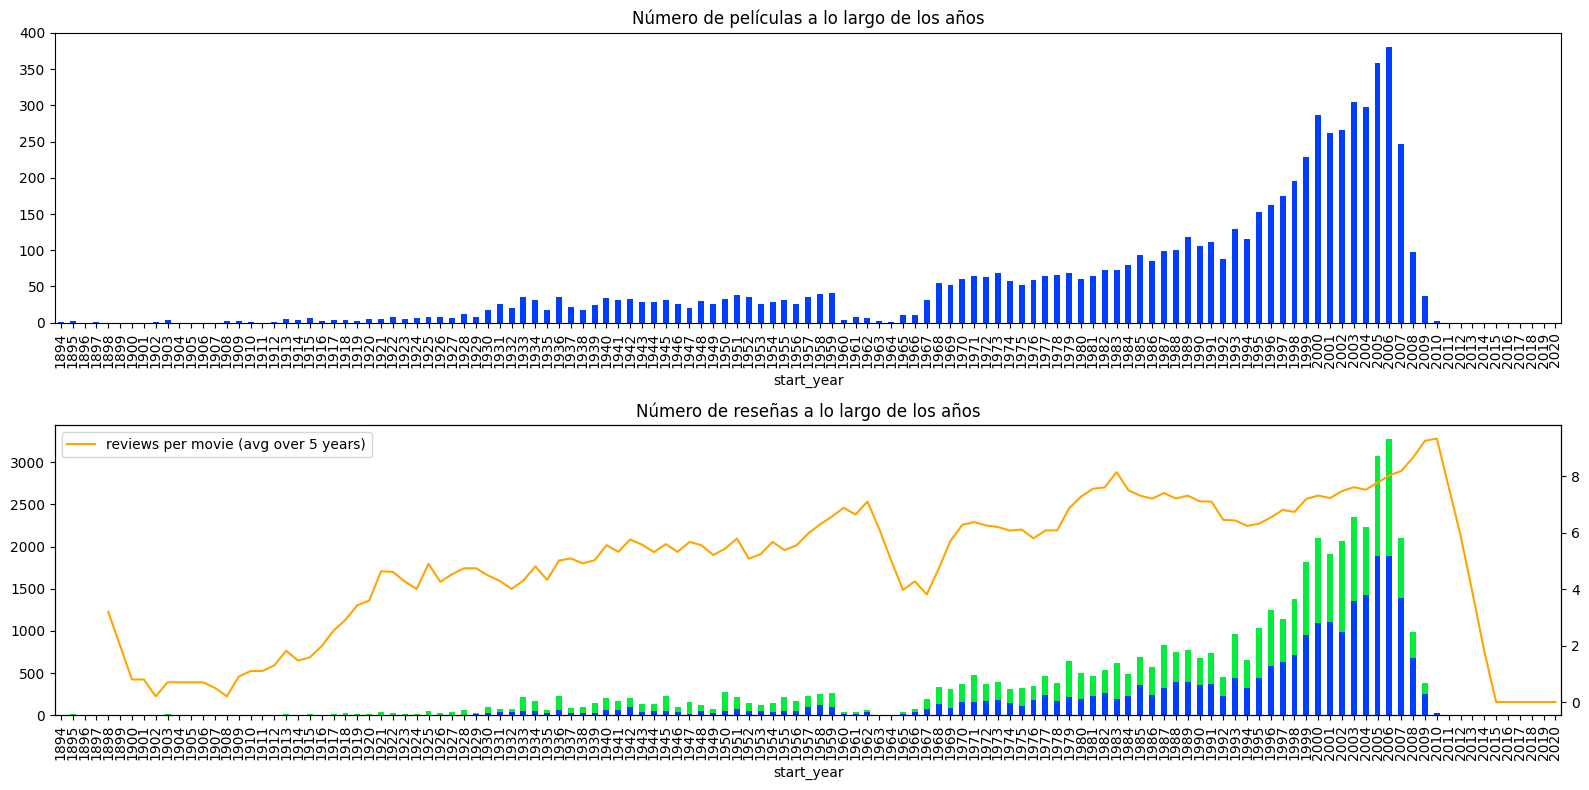

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

En el primer grafico podemos observar que el numero de peliculas entre 1930 y 1959 se mantiene estable y hay una caida de peliculas registradas hasta 1967 hay una ligera tendencia alcista a paratir de ese año a 1989 para hacer un repunte del número de peliculas hasta 1006 donde luego decrece progresivamente.

En el segundo grafico se observa una media movil de las reseñas por peliculas en los ultimos 5 años que tiene una tendencia alcista luego se tiene en los graficos de barras el propio numero de reseñas positivas y negativas por año, vemos que es un grafico similar al primero

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

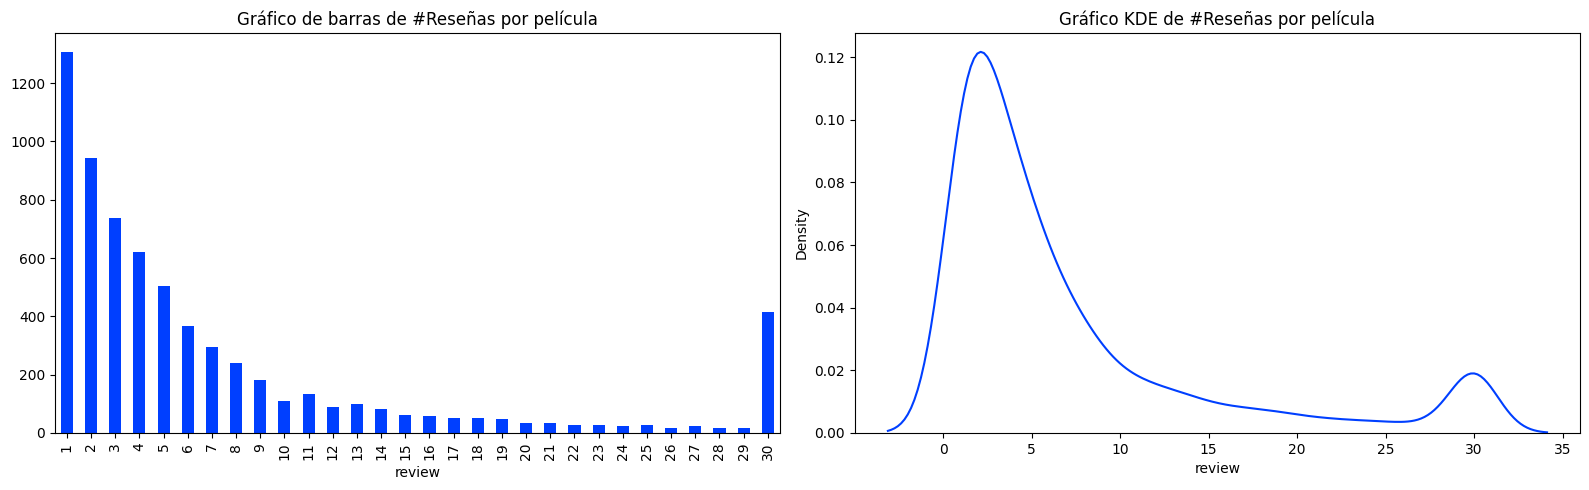

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

Observamos algo logico en la grafica, el numero de reseñas que se hacen por pelicula es del punto más alto y va decreciendo poco a poco, sin embargo hay un pico que llama la atención en las peliculas que tienen 30 reseñas pues son bastantes y se ve una densidad muy amploa entre 0 y 5 reviews en el grafico de la derecha.

In [15]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23616
Name: count, dtype: int64

Se ve que hay un adecuado balance de clases, habría que observar a continuación si esto existe también para las filas etiquetadas para el entrenamiento.

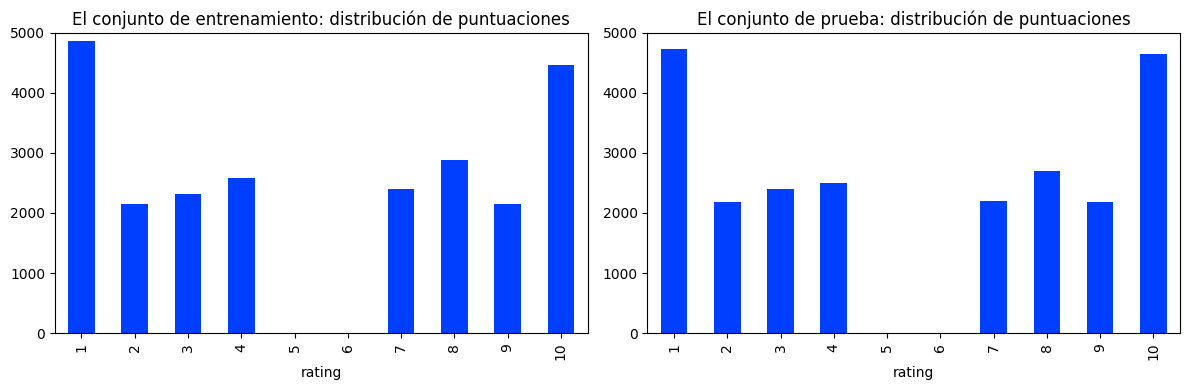

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

En este grafico se observa que las calificaciones para el conjunto de prueba y el de entrenamiento son muy similares

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

C:\Users\evolu\AppData\Local\Temp\ipykernel_23816\1324160450.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\evolu\AppData\Local\Temp\ipykernel_23816\1324160450.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
C:\Users\evolu\AppData\Local\Temp\ipykernel_23816\1324160450.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\evolu\AppData\Local\Temp\ipykernel_23816\1324160450.py:31: UserWarning: 

Support for a

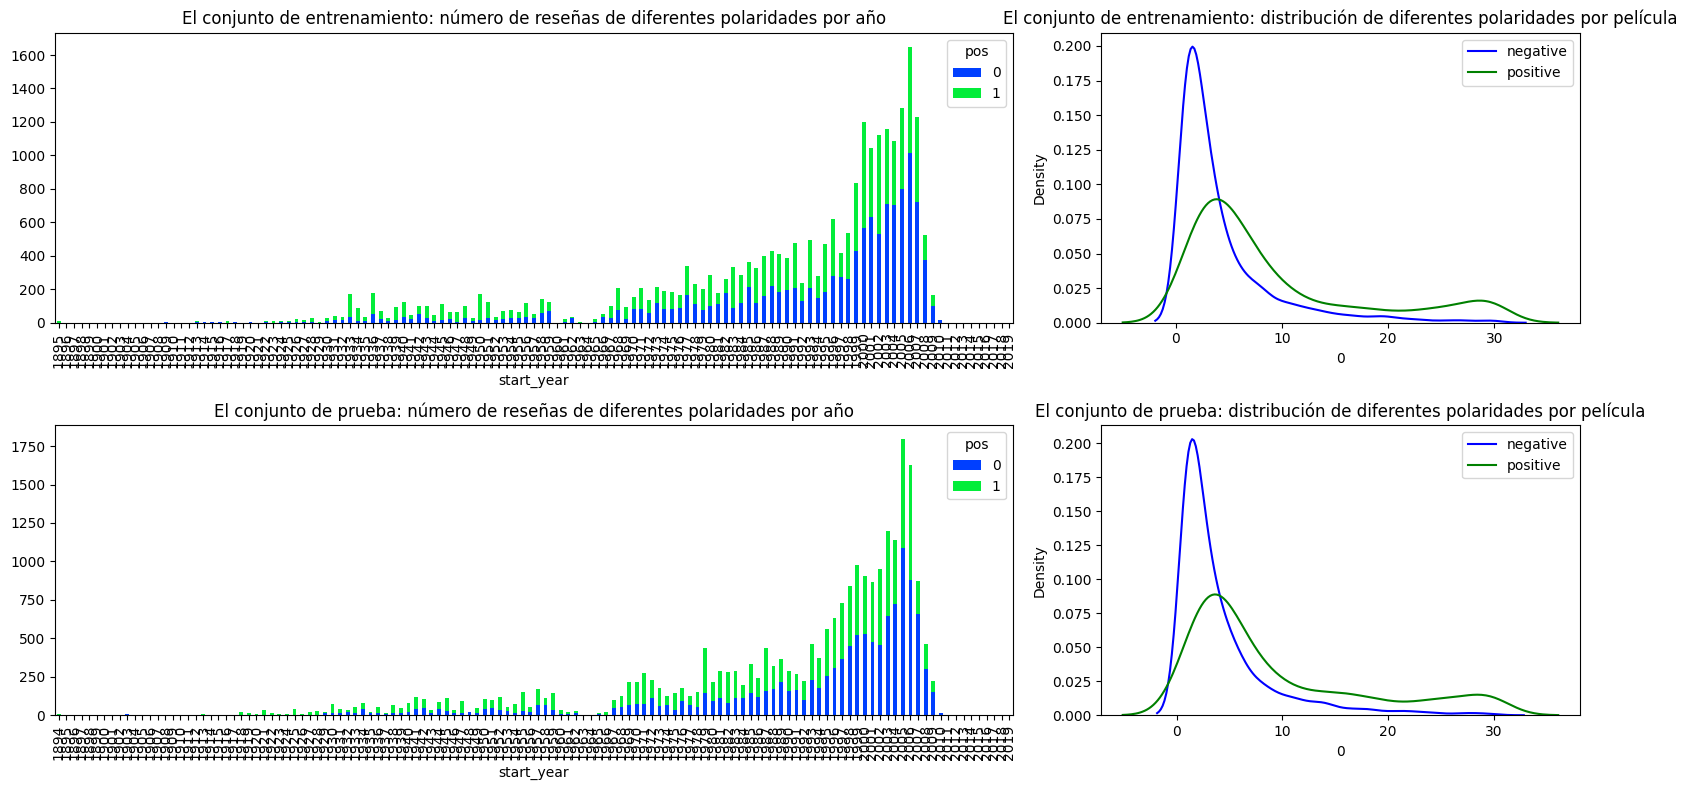

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

En este grafico se puede ver que hay una similitud interesante entre los datos de prueba y entrenamiento, se ve claramente que hay mas reseñas positivas en los graficos del numero de reseñas por año. En la parte de las densidades de los graficos de la derecha en el conjunto de entrenamiento se ve una densidd muy amplia para las reseñas negativas, esto podría indicar que generalmente para la mayoria de las peliculas se dejan pocas reseñas malas, por otra parte las positivas tienen una densidad alrededor de las 5 reseñas del 10%

## Procedimiento de evaluación<a id="titulo_principal_4"></a>

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [18]:
def evaluate_model(model, train_features, train_target, test_features, test_target, param_dist, n_iter=15):
    """
    Esta función evalúa un modelo de clasificación utilizando varios conjuntos de métricas de evaluación
    y genera gráficos visuales para ayudar a interpretar el rendimiento del modelo en los conjuntos de
    datos de entrenamiento y prueba.

    Parámetros:
    model: El modelo de clasificación a evaluar.
    train_features: Las características del conjunto de datos de entrenamiento.
    train_target: Las etiquetas del conjunto de datos de entrenamiento.
    test_features: Las características del conjunto de datos de prueba.
    test_target: Las etiquetas del conjunto de datos de prueba.
    param_dist: Distribución de parámetros para la búsqueda aleatoria.
    n_iter: Número de iteraciones para la búsqueda aleatoria.

    Retorno:
    df_eval_stats: DataFrame con las métricas de evaluación para los conjuntos de entrenamiento y prueba.
    best_model: El mejor modelo encontrado por RandomizedSearchCV.
    """
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='f1',
        cv=3,
        random_state=12345,
        n_jobs=-1
    )
    
    # Ajustar RandomizedSearchCV
    random_search.fit(train_features, train_target)
    
    # Obtener el mejor modelo
    best_model = random_search.best_estimator_
    
    eval_stats = {}  # Diccionario para almacenar las estadísticas de evaluación
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))  # Crear una figura con tres gráficos

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}  # Inicializar un diccionario para el conjunto actual (entrenamiento o prueba)
    
        # Predecir las etiquetas y probabilidades
        pred_target = best_model.predict(features)
        pred_proba = best_model.predict_proba(features)[:, 1]
        
        # Calcular F1 Score para diferentes umbrales
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]
        
        # Calcular la Curva ROC y el AUC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # Calcular la Curva de Precisión-Recall y el APS
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        # Definir el color para el conjunto actual
        color = 'blue' if type == 'train' else 'green'

        # Graficar el F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        
        # Marcar algunos umbrales en el gráfico del F1 Score
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # Graficar la Curva ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        
        # Marcar algunos umbrales en el gráfico de la Curva ROC
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # Graficar la Curva de Precisión-Recall
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        
        # Marcar algunos umbrales en el gráfico de la Curva de Precisión-Recall
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        # Calcular y almacenar la Exactitud y el F1 Score
        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    # Crear un DataFrame con las estadísticas de evaluación
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)  # Imprimir las estadísticas de evaluación
    
    return df_eval_stats, best_model  # Retornar el DataFrame con las estadísticas y el mejor modelo



## Normalización <a id="titulo_principal_5"></a>

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [19]:
pattern = r"[^'a-z\s']"
df_reviews['review_norm'] = df_reviews['review'].str.lower().apply(lambda x: re.sub(pattern, " ", x))# <escribe tu código aquí>

In [20]:
print(df_reviews['review_norm'].head())
print(df_reviews['review'].head())

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made   presenti...
2    there is no real story the film seems more lik...
3    um      a serious film about troubled teens in...
4    i'm totally agree with garryjohal from singapo...
Name: review_norm, dtype: object
0    The pakage implies that Warren Beatty and Gold...
1    How the hell did they get this made?! Presenti...
2    There is no real story the film seems more lik...
3    Um .... a serious film about troubled teens in...
4    I'm totally agree with GarryJohal from Singapo...
Name: review, dtype: object


## División entrenamiento / prueba <a id="titulo_principal_6"></a>

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [16]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


In [17]:
train_target.value_counts()

pos
0    11912
1    11884
Name: count, dtype: int64

## Trabajar con modelos <a id="titulo_principal_7"></a>

### Modelo 1 - Constante

In [23]:
tfidf_vectorizer_1 = TfidfVectorizer()

In [24]:
features_train = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'].copy())
features_test = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'].copy())

In [25]:
from sklearn.dummy import DummyClassifier

model_1 = DummyClassifier(random_state=12345)

param_dist_dummy = {
    'strategy': ['stratified', 'most_frequent', 'prior', 'uniform', 'constant'],
    'constant': [0, 1]  # 'constant' solo se utiliza si la estrategia es 'constant'
}

C:\Users\evolu\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 10 is smaller than n_iter=15. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


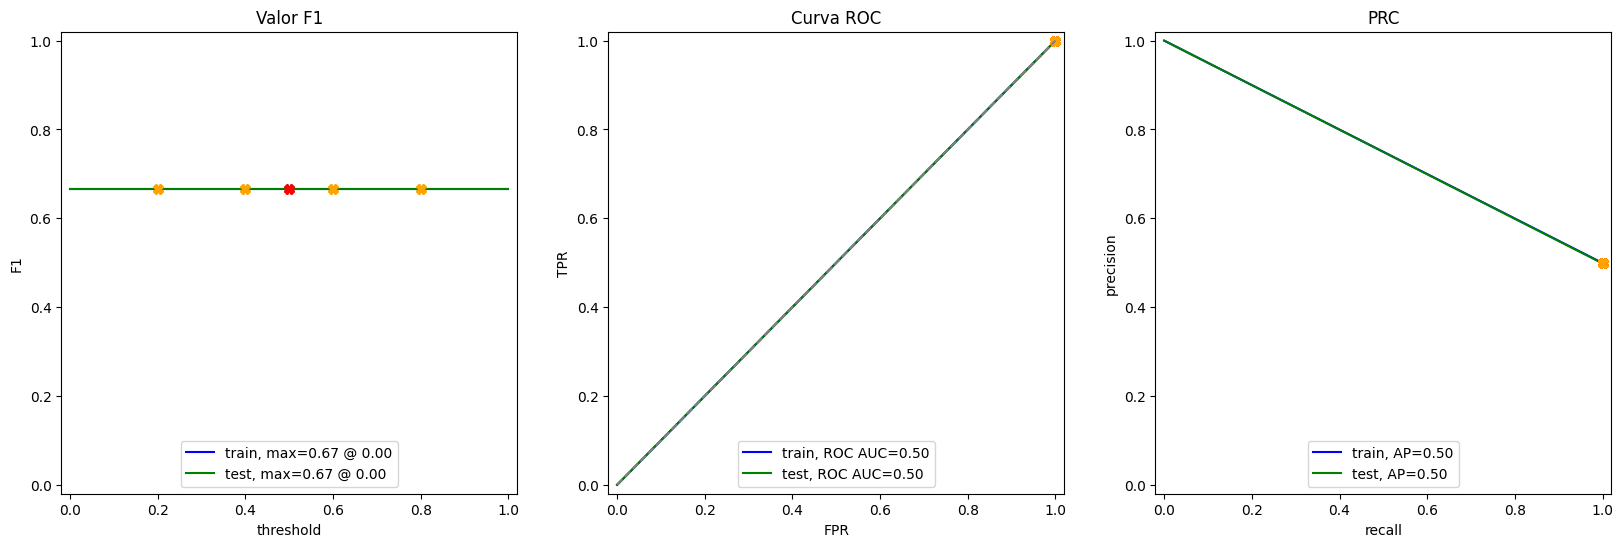

In [26]:
df_evaluete, model_1 = evaluate_model(model_1, features_train, train_target, features_test, test_target, param_dist=param_dist_dummy)

En el modelo ***Dummy*** podemos observar un rendimiento pesimo observo que:
- F1 en su mejor valor llego a 0-67 para train y test en ambos  a el umbral de 0
- En cuanto a la curva ROC observamos una linea porbablemente perfecta que corta en 2 el grafico en diagonal, lo que quiere decir que el modelo no supera un modelo simple como el de lanzar una moneda, esto es muy esperable.
- Para el PRC la curva plana indica que el modelo incoscistente, practicamente al ser una linea recta prodiamos decir que es un modelo de moneda al aire como era de esperar. 

### Modelo 2 - NLTK, TF-IDF y LR

TF-IDF

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords

In [28]:
stopwords = list(stopwords.words('english'))
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stopwords)

In [29]:
features_train = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_norm'].copy())
features_test = tfidf_vectorizer_2.transform(df_reviews_test['review_norm'].copy())

In [30]:
model_2 = LogisticRegression(random_state=12345)

param_dist_logistic = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [100, 200, 500],
    'l1_ratio': [0.1, 0.5, 0.9]  
}

C:\Users\evolu\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


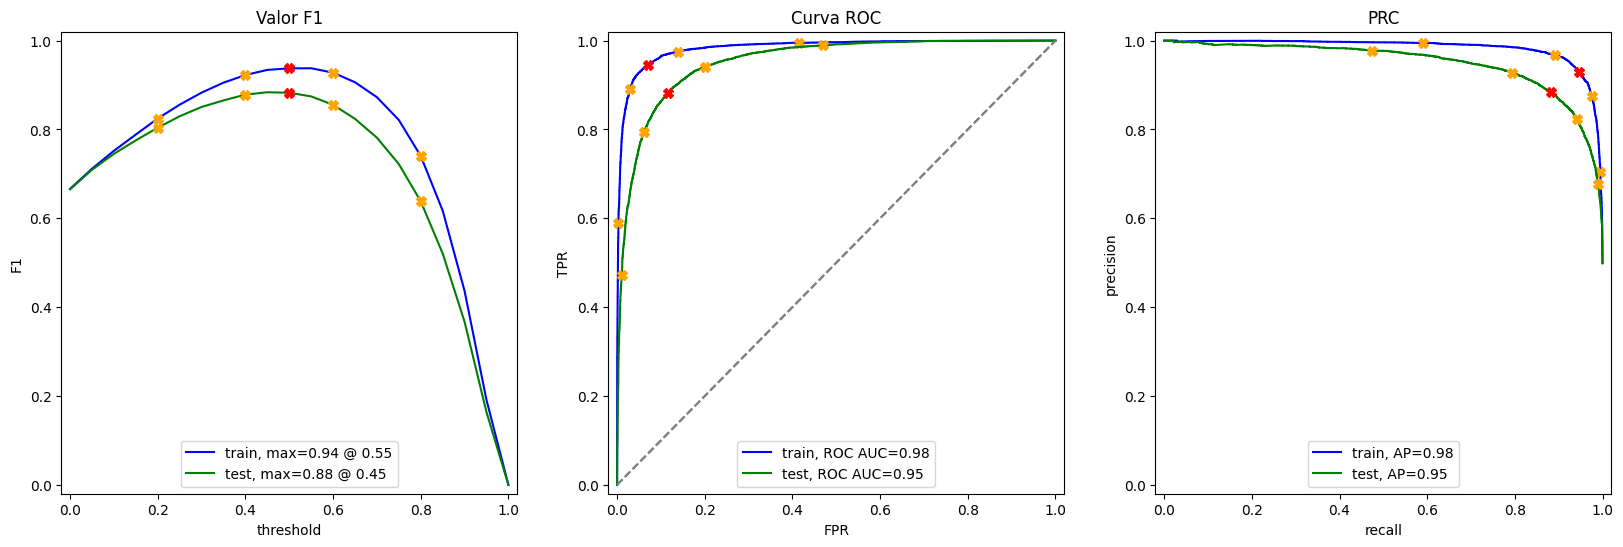

In [31]:
df_evaluete, model_2 = evaluate_model(model_2, features_train, train_target, features_test, test_target, param_dist=param_dist_logistic)

***Modelo 2 - NLTK, TF-IDF y LR***

En este modelo podemos observar lo siguiente:

- En cuanto al valor de F1 se ve un aumento significativo comparado con el anterior modelo de la curva, se obtiene un valor f1 para el testing del 0.88 en el umbral de 0.45 y parece no estar sobreajustado.
- Para la curva ROC se observa un ROC AUC 0.98 para el entrenamiento 0.95 para el test lo cual indica un gran rendimiento con la curva a la tendecia de la parte superior izquierda como es lo optimo.
- Para la PRC pasa igual, una curva con tendencia a tocar la parte superior izquierda indicando un buen rendimiento del modelo 


### Modelo 3 - spaCy, TF-IDF y LR

In [32]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\evolu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
def text_preprocessing_3(text):
    """
    Preprocesa el texto de entrada aplicando lematización utilizando el modelo de spaCy en español.

    Args:
        text (str): El texto de entrada que se va a preprocesar.

    Returns:
        str: El texto preprocesado con los tokens lematizados.
    """
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

In [34]:
df_mod_3_train = df_reviews_train.copy()
df_mod_3_test = df_reviews_test.copy()
df_mod_3_train['review_norm'] = df_mod_3_train['review_norm'].apply(text_preprocessing_3)
df_mod_3_test['review_norm'] = df_mod_3_test['review_norm'].apply(text_preprocessing_3)

In [35]:
tfidf_vectorizer_3 = TfidfVectorizer()

In [36]:
features_train = tfidf_vectorizer_3.fit_transform(df_mod_3_train['review_norm'])
features_test = tfidf_vectorizer_3.transform(df_mod_3_test['review_norm'])

In [37]:
model_3 = LogisticRegression(random_state=12345)

param_dist_logistic = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [100, 200, 500],
    'l1_ratio': [0.1, 0.5, 0.9]  
}

C:\Users\evolu\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


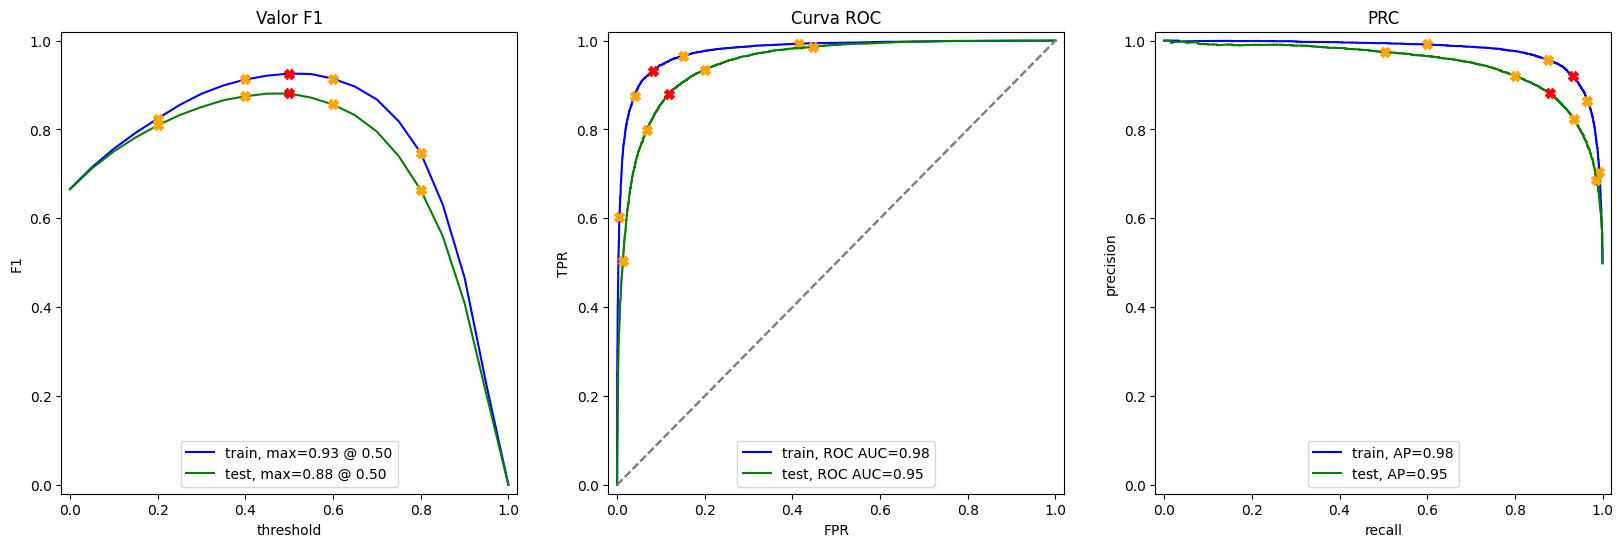

In [38]:
df_evaluete, model_3 = evaluate_model(model_3, features_train, train_target, features_test, test_target, param_dist=param_dist_logistic)

***Modelo 3 - spaCy, TF-IDF y LR***

En este modelo se observo lo siguiente:

- El modelo en la parte de F1 cuenta con un fuerte rendimiento superando el F1 de 0.85 establecido como objetivo, se logra un valor de 0.88 en el conjunto de test
- Para la curva ROC se observa un excelente rendiento con un 0.98 para el entrenamiento y 0.95 para el conjunto de test y una curva inclinada a la parte superior izquierda 
- Por ultimo en el grafico PRC se observa un buen rendimiento para el conjunto de entrenamiento, 0.98 y 0.95 respectivamente con la curva inclinada a la parte superior derecha

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [39]:
from lightgbm import LGBMClassifier
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [40]:
def text_preprocessing_3(text):
    """
    Preprocesa el texto de entrada aplicando lematización utilizando el modelo de spaCy en español.

    Args:
        text (str): El texto de entrada que se va a preprocesar.

    Returns:
        str: El texto preprocesado con los tokens lematizados.
    """
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

In [41]:
df_mod_4_train = df_reviews_train.copy()
df_mod_4_test = df_reviews_test.copy()
df_mod_4_train['review_norm'] = df_mod_4_train['review_norm'].apply(text_preprocessing_3)
df_mod_4_test['review_norm'] = df_mod_4_test['review_norm'].apply(text_preprocessing_3)

In [42]:
tfidf_vectorizer_4 = TfidfVectorizer()

In [43]:
features_train = tfidf_vectorizer_4.fit_transform(df_mod_4_train['review_norm'])
features_test = tfidf_vectorizer_4.transform(df_mod_4_test['review_norm'])

In [44]:
model_4 = LGBMClassifier(random_state=12345)

param_dist_lgbm = {
    'num_leaves': [31, 40, 50, 60],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [-1, 10, 20, 30],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 0.5],
    'reg_lambda': [0, 0.01, 0.1, 0.5]
}

In [45]:
df_evaluete, model_4 = evaluate_model(model_4, features_train, train_target, features_test, test_target, param_dist=param_dist_lgbm)

***Modelo 4 - spaCy, TF-IDF y LGBMClassifier***

Para este modelo similar al modelo 3 solo que con la peculiaridad de ser con LGBMClassifier se concluyo lo siguiente:

- El modelo por numero es excelente sin embargo a comparación de los 2 anteriores tiene una adaptación mejor que incluso pareceria un sobreajuste, sin embargo para la parte de testeo tiene numeros similares a los 2 modelos anteriores
- Para el valor de F1 hay un 1 y un 0.88 para el conjunto de entrenamiento y prueba respectivamente a umbral de 0.5 y 0.45
- Para el valor de ROC es bastante bueno 1 y 0.95 para train y test respectivamente
- Por ultimo en el grafico PRC se observa un buen rendimiento para el conjunto de entrenamiento, 1 y 0.95 respectivamente con la curva inclinada a la parte superior derecha

###  Modelo 9 - BERT

In [ ]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
import torch

def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    """
    Convierte una lista de textos en embeddings utilizando BERT.

    Args:
        texts (list of str): Lista de textos a convertir en embeddings.
        max_length (int, opcional): Longitud máxima de los textos para BERT. Predeterminado es 512.
        batch_size (int, opcional): Tamaño del lote para el procesamiento en BERT. Predeterminado es 100.
        force_device (str, opcional): Dispositivo forzado para usar ('cuda' o 'cpu'). Si no se especifica, se usa 'cuda' si está disponible.
        disable_progress_bar (bool, opcional): Si se establece en True, desactiva la barra de progreso. Predeterminado es False.

    Returns:
        np.ndarray: Matriz de embeddings de los textos.
    """
    ids_list = []
    attention_mask_list = []

    # Convertir textos a IDs de tokens y máscaras de atención
    for text in texts:
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        ids_list.append(encoding['input_ids'].squeeze().tolist())
        attention_mask_list.append(encoding['attention_mask'].squeeze().tolist())

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if device.type == 'cuda' and not torch.cuda.is_available():
        print("Advertencia: CUDA no está disponible en este sistema. Usando CPU en su lugar.")
        device = torch.device('cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    # Obtener embeddings en lotes
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list) / batch_size)), disable=disable_progress_bar):
        ids_batch = torch.LongTensor(ids_list[batch_size * i:batch_size * (i + 1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i:batch_size * (i + 1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())

    return np.concatenate(embeddings)



In [ ]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

Uso del dispositivo cuda.


  0%|          | 0/238 [00:00<?, ?it/s]c:\Program Files\Python312\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
 88%|████████▊ | 209/238 [40:53<05:40, 11.74s/it]    


KeyboardInterrupt: 

In [ ]:
#test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

In [ ]:
print(df_reviews_train['review_norm'].shape)
#print(train_features_9.shape)
#print(test_features_9.shape)
print(train_target.shape)

(23796,)
(23796,)


In [ ]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

In [2]:
# y cargar...
with np.load('features_9.npz') as data:    
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

In [6]:
model_9 = LogisticRegression(random_state=12345)

param_dist_logistic = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [100, 200, 500],
    'l1_ratio': [0.1, 0.5, 0.9]  
}

C:\Users\evolu\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


          train  test
Accuracy   0.87  0.87
F1         0.87  0.86
APS        0.94  0.94
ROC AUC    0.94  0.94


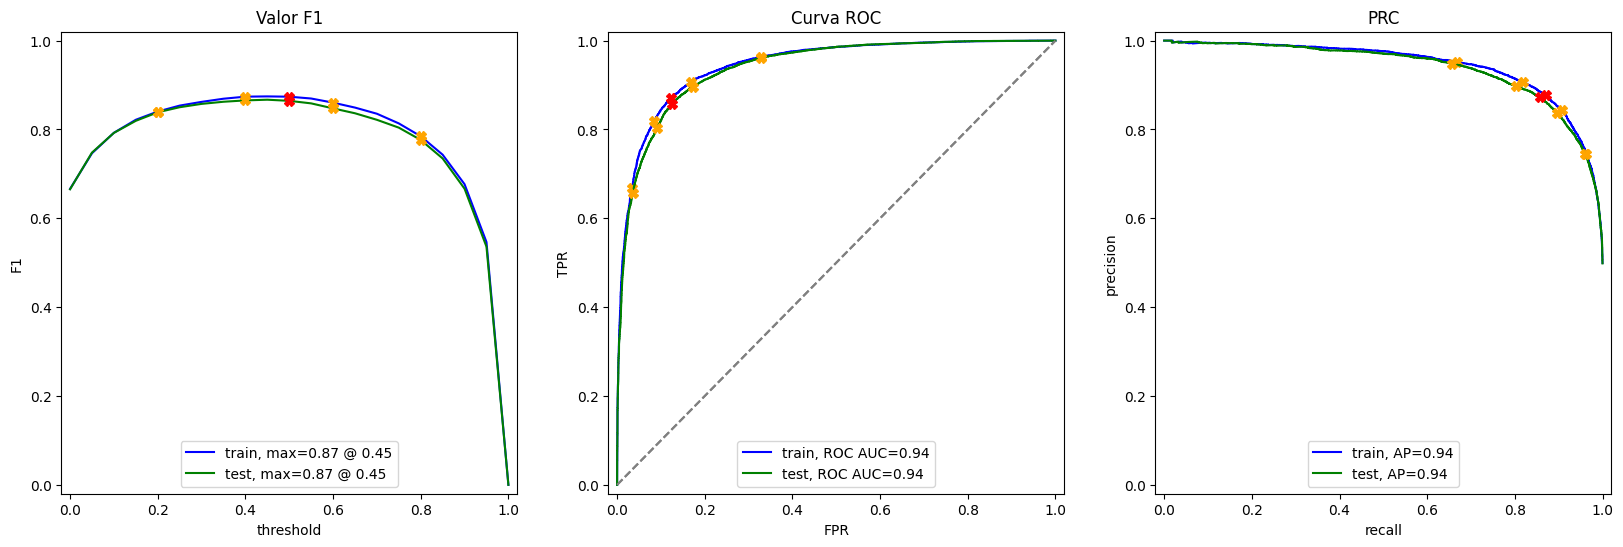

In [18]:
df_eval, model_9 = evaluate_model(model_9, train_features_9, train_target, test_features_9, test_target, param_dist=param_dist_logistic)

In [ ]:
model_9 = LGBMClassifier(random_state=12345)

param_dist_lgbm = {
    'num_leaves': [31, 40, 50, 60],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [-1, 10, 20, 30],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 0.5],
    'reg_lambda': [0, 0.01, 0.1, 0.5]
}

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
          train  test
Accuracy    1.0  0.85
F1          1.0  0.85
APS         1.0  0.93
ROC AUC     1.0  0.93


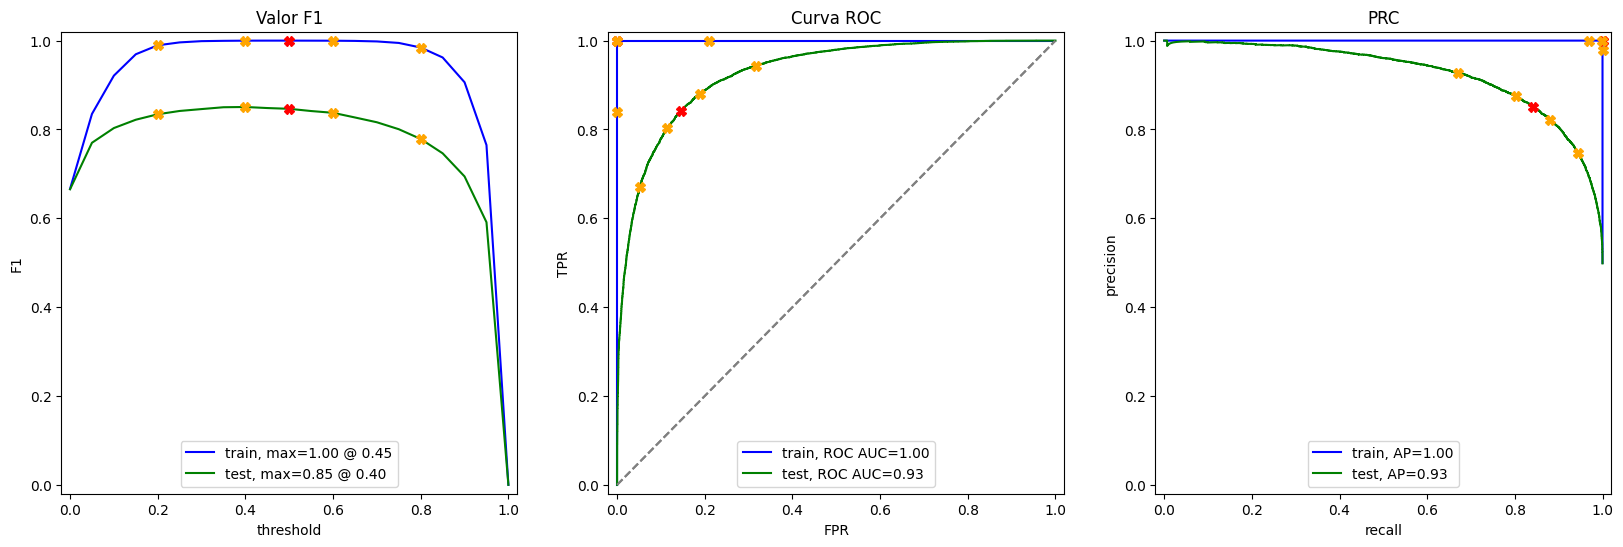

In [ ]:
df_eval, model_9 = evaluate_model(model_9, train_features_9, train_target, test_features_9, test_target, param_dist=param_dist_lgbm)

***Modelo 9 - BERT***

El modelo BERT tiene bastantes peculiaridades, se concluyo lo siguiente:

- A comparación con los demás modelos ambas curbas de train y test en todos los graficos se ajustan bastante y además de tener un buen rendimiento para el la parte de test
- En el valor de F1 ambas curvas se ven mas aplanadas a comparación de las otros modelos, hay un mayor ajuste para otras nuevas reseñas por lo visto
- La curva ROC se observa lo mismo, ambas curvas son muy parecidas sin mencionar que tanto train y test tienen un ROC AUC  del 0.94
- Por ultimo el PRC más de los mismo, ambas lineas ajustadas y con un valor AP de 0.94

## Mis reseñas <a id="titulo_principal_8"></a>

In [ ]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    'i have seen new emotions an that emotions focus on the sentiments and i thing it was a good movie',
    'It is too large and is boring and really low quality scenario',
    # Slightly Positive Reviews
    "The movie was good, although at some points it felt a bit slow. Despite that, the performances were solid.",
    "An interesting story, but I was expecting a bit more excitement. Nonetheless, it's an entertaining film.",
    "The cinematography was excellent, although the plot could have been more original. Overall, a pleasant experience.",
    "I liked the movie, but some characters weren't as developed as I hoped. Still, it was worth watching.",
    "The film had some brilliant moments, but also some predictable scenes. Overall, a good choice for a movie night.",
    
    # Slightly Negative Reviews
    "While the plot had potential, the execution wasn't the best. Some scenes were good, but others left me indifferent.",
    "The performances were decent, but the story was a bit confusing. It wasn’t terrible, but it could have been better.",
    "The movie had good special effects, but the story didn’t fully engage me. Not bad, but I expected more.",
    "There were some interesting moments, but overall the movie was a bit disappointing. Still, not a complete waste of time.",
    "Some parts of the film were entertaining, but others felt forced. I didn’t hate it, but I didn’t love it either.",
    "This movie is the sixth in the saga. Here, Harry discovers secrets from Voldemort's past while preparing to confront him. The movie is darker and more mature than the previous ones, with a lot of action and mystery. The main characters continue to grow, and the performances are great. Visually, it is stunning along with the soundtrack. In summary, it's a very good installment that gets you ready for the grand finale of the saga"
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""
pattern = r"[^a-z\s]"

my_reviews['review_norm'] = my_reviews['review'].str.lower().apply(lambda x: re.sub(pattern, " ", x))# <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>

my_reviews.sample(5)

,review,review_norm
18,"There were some interesting moments, but overa...",there were some interesting moments but overa...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i real...
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middl...
11,"An interesting story, but I was expecting a bi...",an interesting story but i was expecting a bi...
8,i have seen new emotions an that emotions focu...,i have seen new emotions an that emotions focu...


### Modelo 2

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it  not my kind of movie 
0.16:  well  i was bored and felt asleep in the middle of the movie 
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.31:  i didn t expect the reboot to be so good  writers really cared about the source material
0.47:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.04:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.82:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi
0.79:  i have seen new emotions an that emotions focus on the sentiments and i thing it was a good movie
0.04:  it is too large and is boring and really low quality scenario
0.88:  the movie was good  although at some points it felt a bit slow  despite that  the performances were 
0.87:  an interestin

### Modelo 3

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it  not my kind of movie 
0.23:  well  i was bored and felt asleep in the middle of the movie 
0.48:  i was really fascinated with the movie
0.15:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.26:  i didn t expect the reboot to be so good  writers really cared about the source material
0.71:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.04:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.87:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi
0.86:  i have seen new emotions an that emotions focus on the sentiments and i thing it was a good movie
0.07:  it is too large and is boring and really low quality scenario
0.92:  the movie was good  although at some points it felt a bit slow  despite that  the performances were 
0.88:  an interestin

### Modelo 4

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.59:  i did not simply like it  not my kind of movie 
0.57:  well  i was bored and felt asleep in the middle of the movie 
0.69:  i was really fascinated with the movie
0.25:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.44:  i didn t expect the reboot to be so good  writers really cared about the source material
0.89:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.04:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.91:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi
0.95:  i have seen new emotions an that emotions focus on the sentiments and i thing it was a good movie
0.11:  it is too large and is boring and really low quality scenario
0.99:  the movie was good  although at some points it felt a bit slow  despite that  the performances were 
0.88:  an interestin

### Modelo 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.26:  i did not simply like it  not my kind of movie 
0.01:  well  i was bored and felt asleep in the middle of the movie 
0.97:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.19:  i didn t expect the reboot to be so good  writers really cared about the source material
0.91:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.08:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.94:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi
0.96:  i have seen new emotions an that emotions focus on the sentiments and i thing it was a good movie
0.01:  it is too large and is boring and really low quality scenario
0.85:  the movie was good  although at some points it felt a bit slow  despite that  the performances were 
0.99:  an interestin

## Conclusiones <a id="titulo_principal_9"></a>

A lo largo de todo el proyecto y con los datos proporcionados, se llego a lo siguiente:

- Los modelos 2, 3, son bastante interesantes y tienen un excelente desempeño para el conjunto de test y train, también al crear nuevas reseñas lo hacen bastante bien como se puede comprobar en las celdas de arriba y otorgan probabilidades inclinadas hacia al guna postura(reseña positiva o negativa)

- Hablando del 4to modelo, es interesante ver que tiene similares resultados que el 2 y el 3 como se menciono en su sección, la principal diferencia al 3 es que usa *LGBMClassifier* además al ver las probabilidades que entrega al conjunto de nuevos textos se observa que son pronbabilidades no muy inclinadas hacia una postura u otra lo cual me hace pensar que este modelo no es tan seguro del todo, sin embargo entrega resultados excelentes según los graficos.

- Por último toca hablar del modelo de *BERT* que tiene cosas muy interesantes, primeramente se vio un ajuste de las lineas de los 3 graficos bastante alta, además se observa que toma una postura u otra a la hora de clasificar bastante mas radical que los otros modelos, es más sensible a los datos lo que le ayuda a tomar una postura que a mi parecer es mas confiable. 

Como conclusión dire que el modelo 2 y 3 son muy confiables ya que muestra un buen rendimiento general, sin embargo, si se desea un modelo mas potente para ofrecer una clasificación más definitiva BERT es la respuesta excelente a esta necesidad, por último creo que el modelo 4 tiene un balance entre metricas potentes y buena inclinación de postura. 

# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código 
- [ ]  Hay conclusiones 